In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_W4G3 import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Fri Mar 12 18:54:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:2E:00.0 Off |                  N/A |
|106%   86C    P2   190W / 250W |  10314MiB / 11016MiB |     68%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:2F:00.0 Off |                  N/A |
| 68%   

In [3]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/rubato/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [4]:
save_dir = '/data/save/model_W4G3'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [5]:
!ls $save_dir

ls: '/data/save/model_W4G3'에 접근할 수 없습니다: 그런 파일이나 디렉터리가 없습니다


In [6]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 0

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if False:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 115.7MiB
TTS size 28.1MiB
MelEncoder size 8.9MiB
MelDecoder size 17.3MiB
0
done


In [7]:
trainset = LJDataset(tts_hparams)
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [8]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.021262311935424806


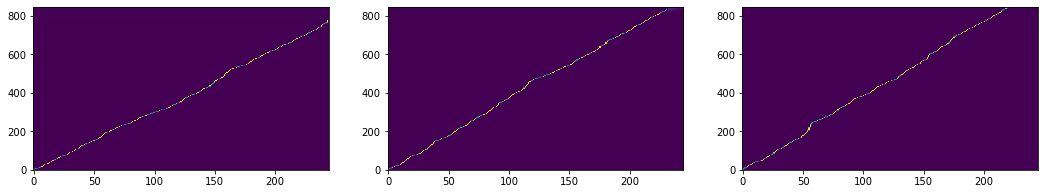

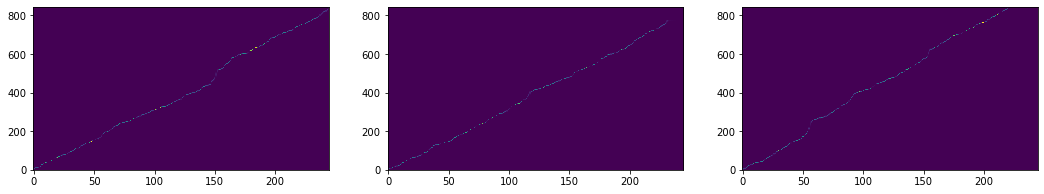

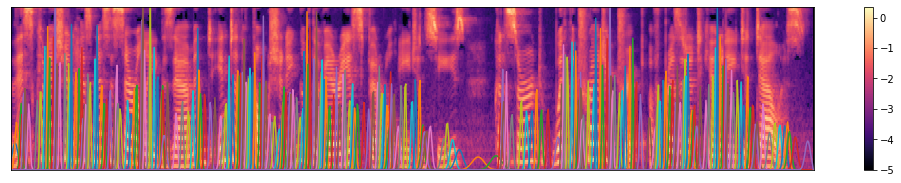

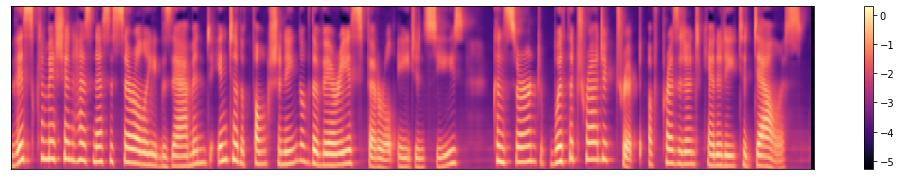

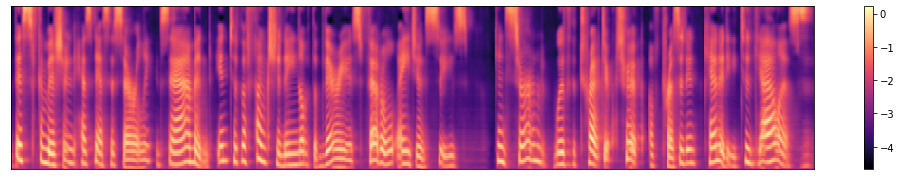

tensor(0.4791, device='cuda:0')
step : 22901 stt : 0.0101 tts : 0.2612 recon : 0.0372 kl : 0.0252 beta : 0.4580
tensor(0.2282, device='cuda:0')
step : 22902 stt : 0.0051 tts : 0.1463 recon : 0.0297 kl : 0.0215 beta : 0.4581
tensor(0.2492, device='cuda:0')
step : 22903 stt : 0.0056 tts : 0.1439 recon : 0.0305 kl : 0.0223 beta : 0.4581
tensor(0.3568, device='cuda:0')
step : 22904 stt : 0.0047 tts : 0.1469 recon : 0.0354 kl : 0.0241 beta : 0.4581
tensor(0.3254, device='cuda:0')
step : 22905 stt : 0.0065 tts : 0.1429 recon : 0.0306 kl : 0.0224 beta : 0.4581
tensor(0.3837, device='cuda:0')
step : 22906 stt : 0.0067 tts : 0.1483 recon : 0.0309 kl : 0.0227 beta : 0.4581
tensor(0.2539, device='cuda:0')
step : 22907 stt : 0.0065 tts : 0.1553 recon : 0.0317 kl : 0.0232 beta : 0.4582
tensor(0.3143, device='cuda:0')
step : 22908 stt : 0.0089 tts : 0.1491 recon : 0.0318 kl : 0.0230 beta : 0.4582
tensor(0.2830, device='cuda:0')
step : 22909 stt : 0.0057 tts : 0.1547 recon : 0.0342 kl : 0.0244 beta :

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 0
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            try:
                _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
                batch_size = _tts_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
                batch_size = _stt_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                plt.figure(figsize=[18, 3])
                _x = batch['mels'].data.cpu().numpy()
                librosa.display.specshow(_x[index])
                plt.colorbar()

                for i in range(_stt_alignments.shape[1]):
                    plt.plot(_stt_alignments[index, i] * 100)

                plt.show()

                plt.figure(figsize=[18, 3])
                _y = tts_outputs['pred'].data.cpu().numpy()
                librosa.display.specshow(_y[index])
                plt.colorbar()
                plt.show()

                plt.figure(figsize=[18, 3])
                _s = samples.data.cpu().numpy()
                librosa.display.specshow(_s[index, :, :_y.shape[2]])
                plt.colorbar()
                plt.show()
            except:
                pass
                      
        step += 1
        

In [ ]:
logger.save(step, model, optimizer)

hundreds of women and children came in every morning to spend the day there, and there was no limitation whatever to the numbers of visitors admitted to the debtors' side.
torch.Size([1, 80, 848]) 0.029007744789123536
{'alignment': 0.0004813671112060547, 'random': 0.0006740093231201172, 'last_conv': 0.01880812644958496, 'z_proj': 0.0007944107055664062, 'cond': 0.00047779083251953125, 'up': 0.00035071372985839844, 'encode': 0.006012439727783203, 'pad': 3.719329833984375e-05, 'enc_conv': 0.0007102489471435547, 'enc_lstm': 0.0050852298736572266}


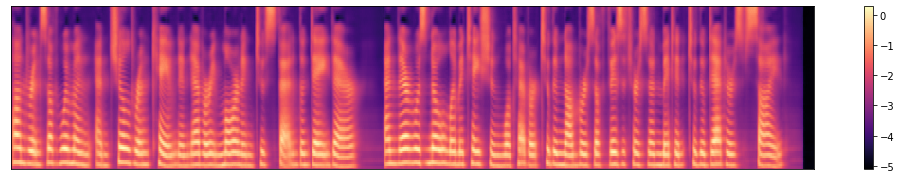

In [34]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 6:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=0.3)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [35]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(217088,)
